## AdaBoost Tutorial

## Install requirements

In [2]:
!pip install pandas
!pip install numpy


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: C:\Users\z004j58u\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: C:\Users\z004j58u\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


## Load data set

Dataset source:

* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

Dataset attributes:

* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [3]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                 names = ["age", 
                            "workclass", 
                            "fnlwgt", 
                            "education", 
                            "education-num", 
                            "marital-status", 
                            "occupation", 
                            "relationship",
                            "race", 
                            "sex", 
                            "capital-gain", 
                            "capital-loss", 
                            "hours-per-week", 
                            "native-country", 
                            "income"], 
                 index_col=False)

display(df.head(3))
print(f"Lenght of the whole dataset: {len(df)}")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


Lenght of the whole dataset: 32561


## Simplify the dataset

The following code creates a simplified version of the dataset to make the following explanations more comprehensible

Attributes:

* Is the person older than 50? - Yes/No
* Is the person male? - Yes/No
* Does the person works more than 40 hours per week? - Yes/No

Target variable:

* Does the person earn more than 50 000 Dollar? - Yes/No

In [4]:
import numpy as np

df['male'] = df['sex'].apply(lambda x : 'Yes' if x.lstrip() == "Male" else "No")
df['>40 hours'] = np.where(df['hours-per-week']>40, 'Yes', 'No')
df['>50 years'] = np.where(df['age']>50, 'Yes', 'No')

# Target
df['>50k income'] = df['income'].apply(lambda x : 'Yes' if x.lstrip() == '>50K' else "No")

df_simpl = df[['male', '>40 hours','>50 years','>50k income']]
df_simpl = df_simpl.head(10)
df_simpl

,male,>40 hours,>50 years,>50k income
0,Yes,No,No,No
1,Yes,No,No,No
2,Yes,No,No,No
3,Yes,No,Yes,No
4,No,No,No,No
5,No,No,No,No
6,No,No,No,No
7,Yes,Yes,Yes,Yes
8,No,Yes,No,Yes
9,Yes,No,No,Yes


## Find the first Decision Stump

* In the first step we are calculating the gini index for each attribute
* We are selecting the attribute as root node of our first decision stump, that shows the lowest gini index (highest gini gain)

![title](img/images.svg)

In [5]:
def calc_weighted_gini_index(attribute, df):
    '''
    Args:
        df: the trainings dataset stored in a data frame
        attribute: the chosen attribute for the root node of the tree
    Return:
        Gini_attribute: the gini index for the chosen attribute
    '''
    d_node = df[[attribute, '>50k income']]
    
    # number of records in the dataset (=10, for the simple example)
    n = len(d_node)
    
    # number of values "Yes" and "No" for the target variable ">50k income" in the root node
    n_1 = len(d_node[d_node[attribute] == 'Yes'])
    n_2 = len(d_node[d_node[attribute] == 'No'])

    # count "Yes" and "No" values for the target variable ">50k income" in each leafe
    # left leafe, D_1
    n_1_yes = len(d_node[(d_node[attribute] == 'Yes') & (d_node[">50k income"] == 'Yes')])
    n_1_no = len(d_node[(d_node[attribute] == 'Yes') & (d_node[">50k income"] == 'No')])
    
    # right leafe, D_2
    n_2_yes = len(d_node[(d_node[attribute] == 'No') & (d_node[">50k income"] == 'Yes')])
    n_2_no = len(d_node[(d_node[attribute] == 'No') & (d_node[">50k income"] == 'No')])

    # Gini index of the left leafe
    Gini_1 = 1-(n_1_yes/(n_1_yes + n_1_no)) ** 2-(n_1_no/(n_1_yes + n_1_no)) ** 2
    
    # Gini index of the right leafe
    Gini_2 = 1-(n_2_yes/(n_2_yes + n_2_no)) ** 2-(n_2_no/(n_2_yes + n_2_no)) ** 2

    # weighted Gini index for the selected feature (=attribute) as root node
    Gini_attribute = (n_1/n) * Gini_1 + (n_2/n) * Gini_2
    Gini_attribute = round(Gini_attribute, 3)
    
    #print(f'Gini_{attribute} = {Gini_attribute}')
    
    return Gini_attribute


def find_attribute_that_shows_the_smallest_gini_index(df):
    '''
    Args:
        df: the trainings dataset stored in a data frame
    Return:
        selected_root_node_attribute: the attribute/feature that showed the lowest gini index
    '''
    ################################################################################################################
    # calculate gini index for each attribute in the dataset and store them in a list
    ################################################################################################################
    attributes = []
    gini_indexes = []

    for attribute in df.columns[:-1]:
        # calculate gini index for attribute as root note using the defined function "calc_weighted_gini_index"
        gini_index = calc_weighted_gini_index(attribute, df)

        attributes.append(attribute)
        gini_indexes.append(gini_index)


    ################################################################################################################    
    # create a data frame using the just calculated gini index for each feature/attribute of the dataset
    ################################################################################################################
    print("Calculated Gini indexes for each attribute of the data set:")
    d_calculated_indexes = {'attribute':attributes,'gini_index':gini_indexes}
    d_indexes_df = pd.DataFrame(d_calculated_indexes)
    display(d_indexes_df)


    # Find the attribute for the first stump, the attribute where the Gini index is 
    #lowest the thus the Gini gain is highest")
    selected_root_node_attribute = d_indexes_df.min()["attribute"]
    print(f"Attribute for the root node of the stump: {selected_root_node_attribute}")
    
    return selected_root_node_attribute

################################################################################################################
# to build the first stump we are using the orginial dataset as train dataset 
################################################################################################################
df_step_1 = df_simpl

selected_root_node_attribute = find_attribute_that_shows_the_smallest_gini_index(df_step_1)

Calculated Gini indexes for each attribute of the data set:


,attribute,gini_index
0,male,0.417
1,>40 hours,0.175
2,>50 years,0.400


Attribute for the root node of the stump: >40 hours


## Calculate weighted error

,>40 hours,>50k income,sample_weight,chosen_stump_incorrect,error
0,No,No,0.1,0,0.0
1,No,No,0.1,0,0.0
2,No,No,0.1,0,0.0
3,No,No,0.1,0,0.0
4,No,No,0.1,0,0.0
5,No,No,0.1,0,0.0
6,No,No,0.1,0,0.0
7,Yes,Yes,0.1,0,0.0
8,Yes,Yes,0.1,0,0.0
9,No,Yes,0.1,1,0.1


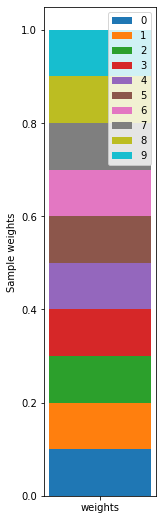

Error of the stump [>40 hours] = 0.1


In [6]:
import helper_functions

def calculate_error_for_chosen_stump(df, selected_root_node_attribute): 
    '''
    Attributes:
        df: trainings data set
        selected_root_node_attribute: name of the column used for the root node of the stump
    
    Return:
        df_extended: df extended by the calculated weights and error
        error: calculated error for the stump - sum of the weights of all samples that were misclassified by the decision stub
    '''
    # add column for the sample weight, for the first step its simply defined as 1/n, so the sum of all weights is 1
    df["sample_weight"] = 1/len(df)

    df[selected_root_node_attribute]
    df[">50k income"]

    # in binary classification, we have two ways to build the tree. (1) That attribute and target value show the same value or (2) attribute and target value show the opposite value
    # we choose the one which shows less errors

    df["stump_1_incorrect_v1"] = np.where(((df[selected_root_node_attribute] == "Yes") & (df[">50k income"] == "Yes")) |
                                             ((df[selected_root_node_attribute] == "No") & (df[">50k income"] == "No")),0,1)
    df["stump_1_incorrect_v2"] = np.where(((df[selected_root_node_attribute] == "Yes") & (df[">50k income"] == "No")) |
                                             ((df[selected_root_node_attribute] == "No") & (df[">50k income"] == "Yes")),0,1)

    # select the stump with fewer samples misclassified
    if sum(df['stump_1_incorrect_v1']) <= sum(df["stump_1_incorrect_v2"]): 
        df["chosen_stump_incorrect"] = df['stump_1_incorrect_v1']
    else:
        df["chosen_stump_incorrect"] = df['stump_1_incorrect_v2']

    # drop the columns for the two versions of the tree
    df = df.drop(['stump_1_incorrect_v1', 'stump_1_incorrect_v2'], axis=1)

    # calculate the error by multiplying sample weight and chosen_stump
    df["error"] = df["sample_weight"] * df["chosen_stump_incorrect"]
    error = sum(df["error"])

    # data frame extended by the weights, errors, etc.
    df_extended = df
    
    # display extended dataset
    display(df_extended[[selected_root_node_attribute,">50k income","sample_weight", "chosen_stump_incorrect", "error"]])
    
    # display matplotlib
    helper_functions.plot_weights(df_extended)
    
    print(f'Error of the stump [{selected_root_node_attribute}] = {error}')

    return df_extended, error

# call function to calculate error for the selected stump
df_extended_1, error = calculate_error_for_chosen_stump(df_step_1, selected_root_node_attribute)

## Calculate amount of say of the stump

Calculate weighted error rate of the weak classifier which defines with which weighting the predictions of the stump are considered in the entire ensemble model

Weighted error rate of the weak classifier / Amount of say = 1.099


C:\Users\z004j58u\repos\sonstiges\Ada-Boost-Tutorial\helper_functions.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_n = 1/2 * np.log((1-e)/e)
C:\Users\z004j58u\repos\sonstiges\Ada-Boost-Tutorial\helper_functions.py:43: RuntimeWarning: divide by zero encountered in log
  alpha_n = 1/2 * np.log((1-e)/e)


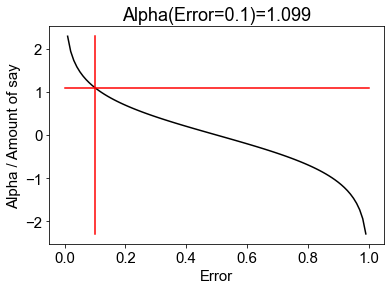

In [7]:
import matplotlib.pyplot as plt
from datetime import datetime

# calculate the amount of say, the weighted error rate of the weak classifier
alpha = 1/2 * np.log((1-error)/error)
print(f'Weighted error rate of the weak classifier / Amount of say = {round(alpha,3)}')

helper_functions.plot_alpha(alpha, error)

## Adjustment of the sample weights

Samples where the current stump makes errors should be weighted more heavily when training the next stump

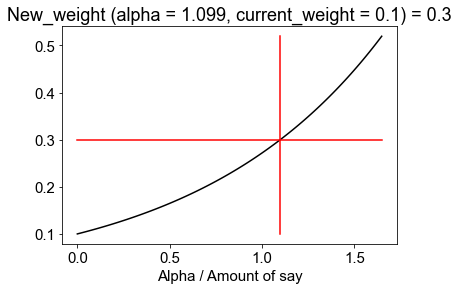

In [8]:
def plot_scale_of_weights(alpha, current_sample_weight, incorrect):

    import math

    alpha_list = []
    new_weights = []

    if incorrect == 1:
        new_weight = current_sample_weight * math.exp(alpha)

        for alpha_n in np.linspace(0, alpha*1.5, num=100):
            scale = current_sample_weight * math.exp(alpha_n)

            alpha_list.append(alpha_n)
            new_weights.append(scale)
    else:
        new_weight = current_sample_weight * math.exp(-alpha)

        for alpha_n in np.linspace(0, alpha*1.5, num=100):
            scale = current_sample_weight * math.exp(-alpha_n)

            alpha_list.append(alpha_n)
            new_weights.append(scale)
            
            
    font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 15}

    plt.rc('font', **font)

    plt.plot(alpha_list, new_weights, color='black')
    plt.plot(np.linspace(alpha, alpha, num=100), new_weights, color='red')
    plt.plot(np.linspace(0, alpha*1.5, num=100), np.linspace(new_weight, new_weight, num=100), color='red')

    #plt.ylabel('Alpha / Amount of say')
    plt.xlabel('Alpha / Amount of say')
    plt.title(f'New_weight (alpha = {round(alpha,3)}, current_weight = {round(current_sample_weight, 3)}) = {round(new_weight,3)}')
    # define plot name
    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

    plt.savefig(r'.\plots\sample_weights_' + dt_string + '.svg')
    plt.show()
    
    return new_weight
    
new_weight = plot_scale_of_weights(alpha, current_sample_weight=0.1, incorrect = 1)

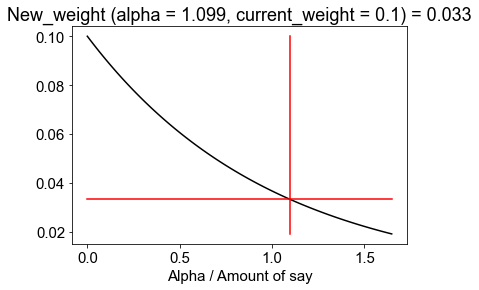

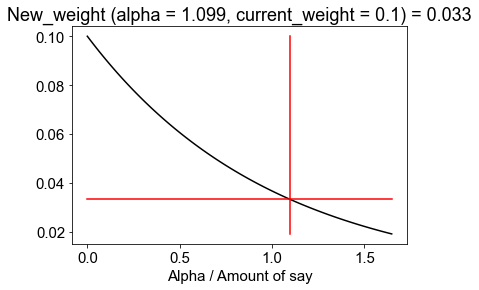

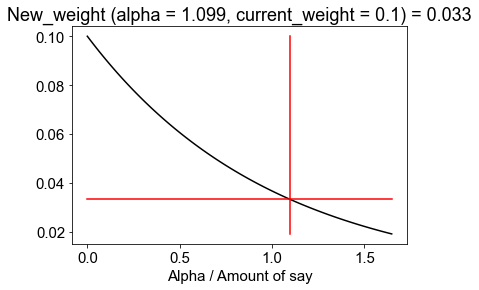

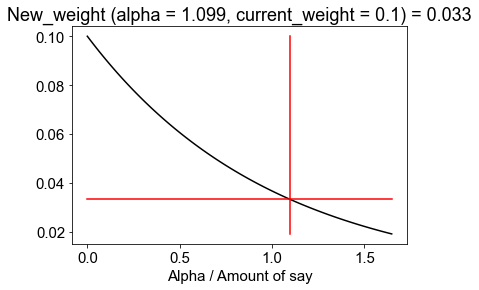

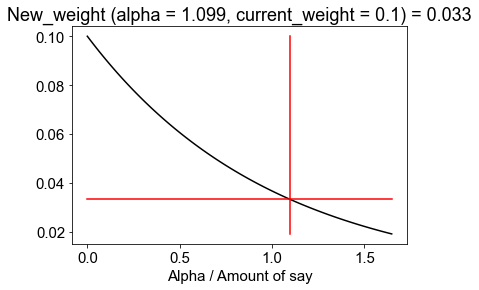

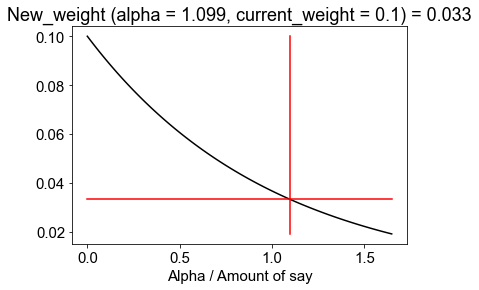

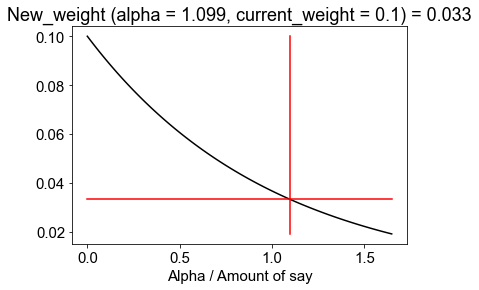

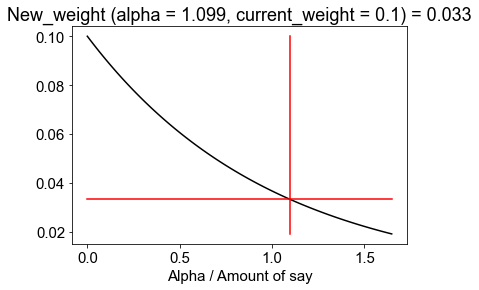

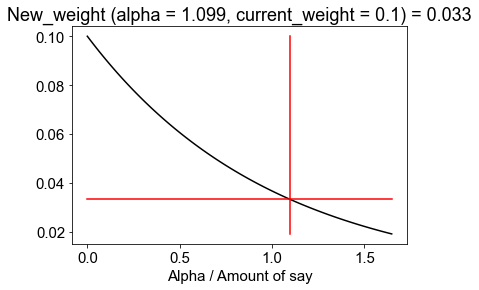

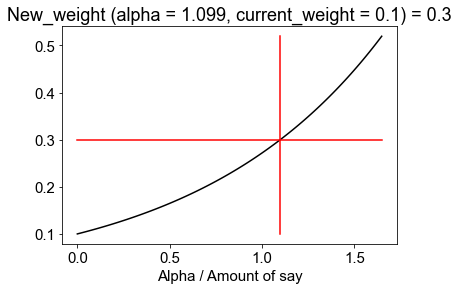

In [9]:
def update_sample_weights(df_extended_1):    
    # calculate the new weights for the misclassified samples
    def calc_new_sample_weight(x, alpha):

        new_weight = plot_scale_of_weights(alpha, x["sample_weight"], x["chosen_stump_incorrect"])

        return new_weight

    df_extended_1["new_sample_weight"] = df_extended_1.apply(lambda x: calc_new_sample_weight(x, alpha), axis=1)

    df_extended_2 = df_extended_1[["male", ">40 hours", ">50 years", ">50k income", "new_sample_weight"]]
    df_extended_2 = df_extended_2.rename(columns={"new_sample_weight": "sample_weight"}, errors="raise")

    # normalize weights
    df_extended_2["sample_weight"] = df_extended_2["sample_weight"] * 1/df_extended_2["sample_weight"].sum()
    df_extended_2["sample_weight"].sum()

    return df_extended_2
    
df_extended_2 = update_sample_weights(df_extended_1)

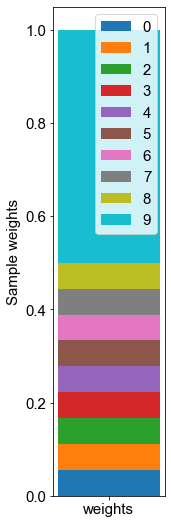

In [10]:
# plot new normalized weights
helper_functions.plot_weights(df_extended_2)

## Create a new bootstraped dataset

In [11]:
import random

# define bins for selecting new instances
df_extended_2["cum_sum_upper"] = df_extended_2["sample_weight"].cumsum()
df_extended_2["cum_sum_low"] = [0] + df_extended_2["cum_sum_upper"][0:9].to_list()

df_extended_2

,male,>40 hours,>50 years,>50k income,sample_weight,cum_sum_upper,cum_sum_low
0,Yes,No,No,No,0.055556,0.055556,0.000000
1,Yes,No,No,No,0.055556,0.111111,0.055556
2,Yes,No,No,No,0.055556,0.166667,0.111111
3,Yes,No,Yes,No,0.055556,0.222222,0.166667
4,No,No,No,No,0.055556,0.277778,0.222222
5,No,No,No,No,0.055556,0.333333,0.277778
6,No,No,No,No,0.055556,0.388889,0.333333
7,Yes,Yes,Yes,Yes,0.055556,0.444444,0.388889
8,No,Yes,No,Yes,0.055556,0.500000,0.444444
9,Yes,No,No,Yes,0.500000,1.000000,0.500000


In [12]:
# create new dataset
import random

new_data_set = []

for i in range(0,len(df_extended_2),1):
    random_number = random.randint(0, 100)*0.01
    
    if i == 0:
        picked_instance = df_extended_2[(df_extended_2["cum_sum_low"]<random_number) & (df_extended_2["cum_sum_upper"]>random_number)]
        new_data_set = picked_instance
    else:
        picked_instance = df_extended_2[(df_extended_2["cum_sum_low"]<random_number) & (df_extended_2["cum_sum_upper"]>random_number)]
        new_data_set = pd.concat([new_data_set, picked_instance], ignore_index=True)
            
new_data_set

,male,>40 hours,>50 years,>50k income,sample_weight,cum_sum_upper,cum_sum_low
0,Yes,Yes,Yes,Yes,0.055556,0.444444,0.388889
1,No,Yes,No,Yes,0.055556,0.500000,0.444444
2,Yes,No,No,Yes,0.500000,1.000000,0.500000
3,Yes,No,No,Yes,0.500000,1.000000,0.500000
4,No,Yes,No,Yes,0.055556,0.500000,0.444444
5,Yes,No,No,No,0.055556,0.166667,0.111111
6,Yes,No,No,Yes,0.500000,1.000000,0.500000
7,Yes,No,No,Yes,0.500000,1.000000,0.500000
8,Yes,No,No,No,0.055556,0.055556,0.000000
9,Yes,No,Yes,No,0.055556,0.222222,0.166667


## Use the new dataset to find the next stump

In [13]:
################################################################################################################
# find the root node for the second stump
################################################################################################################
df_step_2 = new_data_set[["male", ">50 years", ">50k income"]]

selected_root_node_attribute_2 = find_attribute_that_shows_the_smallest_gini_index(df_step_2)

Calculated Gini indexes for each attribute of the data set:


,attribute,gini_index
0,male,0.375
1,>50 years,0.400


Attribute for the root node of the stump: >50 years


,>50 years,>50k income,sample_weight,chosen_stump_incorrect,error
0,Yes,Yes,0.1,1,0.1
1,No,Yes,0.1,0,0.0
2,No,Yes,0.1,0,0.0
3,No,Yes,0.1,0,0.0
4,No,Yes,0.1,0,0.0
5,No,No,0.1,1,0.1
6,No,Yes,0.1,0,0.0
7,No,Yes,0.1,0,0.0
8,No,No,0.1,1,0.1
9,Yes,No,0.1,0,0.0


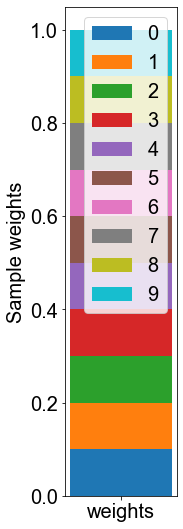

Error of the stump [>50 years] = 0.30000000000000004


In [18]:
################################################################################################################
# 2. calculate error for the selected stump
################################################################################################################
df_extended_new_1, error_step_2 = calculate_error_for_chosen_stump(df_step_2, selected_root_node_attribute_2)

In [19]:
################################################################################################################
# 3. calculate the amount of say, the weighted error rate of the weak classifier
################################################################################################################
alpha_step_2 = 1/2 * np.log((1-error_step_2)/error_step_2)
print(f"Amount of say for step 2 is: {round(alpha_step_2, 3)}")

Amount of say for step 2 is: 0.424


## Build the ensemble model

In [20]:
alpha_step_1 = alpha
print(f"Amount of say for the first stump: {round(alpha_step_1,3)}")
      
alpha_step_2 = alpha_step_2
print(f"Amount of say for the second stump: {round(alpha_step_2,3)}")


##########################################################################################
# Make a prediction:
# Suppose a person lives in the U.S., is 30 years old, and works about 42 hours per week.
##########################################################################################

# the first stump uses the hours worked per week (>40 hours) as the root node
# if the regular working hours per week is above 40 hours, the stump would say that the person earns more than 50 k
# otherwise, the income would be classified as below 50 k
F_1 = 1

# the second stump uses the age (>50 years) as root node
# if you are over 50 years old, you are more likely to have an income of more than 50 k
# in this case, our second weak learner would classifier the target variable (>50 k income) as a 'Yes' or 1
# otherwise as a 'No' or 0
F_2 = 0

# calculate the result of the ensemble model
F_over_50_k = alpha_step_1 * 1 + alpha_step_2 * 0
F_below_50_k = alpha_step_1 * 0 + alpha_step_2 * 1

if F_over_50_k > F_below_50_k:
    print("The person has an income of more than 50 k")
else:
    print("The person has an income below 50 k")

Amount of say for the first stump: 1.099
Amount of say for the second stump: 0.424
The person has an income of more than 50 k


In [21]:
!git add .
!git config git.mail "dmnkplzr@googlemail.com"
!git config git.name "Dominik Polzer"
!git commit -m "update"
!git push

The file will have its original line endings in your working directory


[main b1c56f0] update
 2 files changed, 1180 insertions(+), 133 deletions(-)
 create mode 100644 plots/weights_31_07_2022_21_07_02.svg


To github.com:polzerdo55862/Ada-Boost-Tutorial.git
   6f584a4..b1c56f0  main -> main
